## 05 훈련 노하우를 배웁니다

### 05-1 검증세트를 나누고 전처리 과정

목표 : 어느 데이터 세트에만 치우친 모델을 만들지 않는 것.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 로지스틱 회귀로 모델 훈련하고 평가하기

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y, test_size =0.2, random_state=42)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

테스트 세트에서 정확도는 약 83%. 이 성능이 만족스럽지 않다면 다른 손실함수 사용 가능.    
그런데 loss와 같은 매개변수 값은 가중치나 절편처럼 알아서 학습되는 것이 아닌 직접 선택해야함.(하이퍼파라미터)    
loss의 값을 바꾸면 성능이 정말 좋아지는지 확인 

In [8]:
# 서포트벡터머신으로 모델훈련하고 평가하기
# SGDClassifier클래스의 loss매개변수를 log에서 hinge로 바꾸면 선형서포트벡터머신.
# SVM(Support Vector Machine): 훈련데이터의 클래스를 구분하는 경계선을 찾는 작업

sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test,y_test)

0.9385964912280702

93%. 로지스틱 회귀로 만든 모델의 성능보다 더 좋아짐. loss매개변수에 다른 값을 적용했듯이 SGDClassifier 클래스의 다른 매개변수들을 바꾸는 작업을 '모델을 튜닝한다'라고 함.    

테스트세트로 모델을 튜닝하면 실전에서 좋은 성능을 기대하기 어려움. 테스트 세트로 모델을 튜닝하면 '테스트세트의 정보가 모델에 새어나가기 때문'에 모델의 일반화 성능이 왜곡 됨.

In [9]:
# 검증세트 준비
# 모델을 튜닝할 때 테스트 세트를 사용하지 않으면 됨.
# 모델을 튜닝하는 용도의 세트는 검증세트(validation set)라고하며, 훈련세트를 조금 떼어 만듦.

# 1.데이터세트 준비하기
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify =y,
                                                            test_size =0.2, random_state=42)

In [10]:
# 2.검증 세트 분할하기.
# 전체 데이터 세트를 8:2로 나누어 훈련/테스트세트를 만들고 다시 훈련세트를 8:2로 나누어 훈련/검증세트 만듦.

x_train, x_val, y_train, y_val = train_test_split(x_train_all,y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train),len(x_val))

364 91


In [11]:
# 검증세트 사용해 모델 평가하기.

sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train,y_train)
sgd.score(x_val,y_val)    # 훈련세트의 크기가 줄어들어서 평가점수가 낮아짐.

0.6923076923076923

### 데이터 전처리와 특성의 스케일

['mean perimeter' 'mean area']


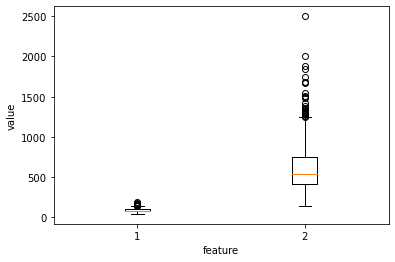

In [12]:
# 스케일을 조정하지 않고 모델 훈련해보기
# 1. 훈련데이터 준비하고 스케일 비교하기

print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:,2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [23]:
# 스케일이 다른 두 특성에 경사하강법알고리즘을 적용하면 가중치가 어떻게 변할까?
# 2. 가중치를 기록할 변수와 학습률 파라미터 추가하기

class SingleLayer:
    
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x *err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def activation(self,z):
        a = 1 / (1 + np.exp(-z))
        return a
    
# 3.가중치 기록하고 업데이트 양 조절하기
# fit()메서드에서 가중치가 바뀔때마다 w_history리스트에 가중치 기록
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i],err)
                self.w -= w_grad
                self.b -= b_grad
                # 가중치 기록
                self.w_history.append(self.w.copy)
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [13]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b    # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err          # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        np.random.seed(42)                         # 랜덤 시드를 지정합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다.
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                # 그래디언트에서 페널티 항의 미분 값을 더합니다
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad         # 가중치 업데이트
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) >= 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     # 정방향 계산
            a = self.activation(z)         # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [14]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

In [15]:
# 4.모델 훈련하고 평가하기

layer1 = SingleLayer()
layer1.fit(x_train,y_train)
layer1.score(x_val,y_val)

0.9120879120879121

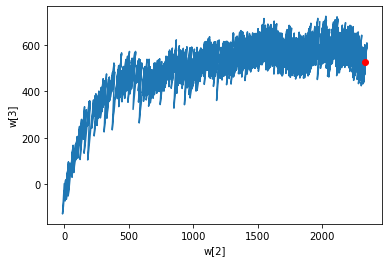

In [16]:
# 5. w_history 그래프

# w2 = []
# w3 = []
# for w in layer1.w_history:
#     w2.append(w[2])
#     w3.append(w[3])
# plt.plot(w2,w3)
# plt.plot(w2[-1],w3[-1],'ro')
# plt.xlabel('w[2]')
# plt.ylabel('w[3]')
# plt.show()

w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

### 스케일을 조정해 모델 훈련

- 표준화 : 특성값에서 평균을 빼고 표준편차로 나눔. 표준화를 하면 평균이 0이고 분산이 1.


In [17]:
# 1. 넘파이로 표준화 구현하기

train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

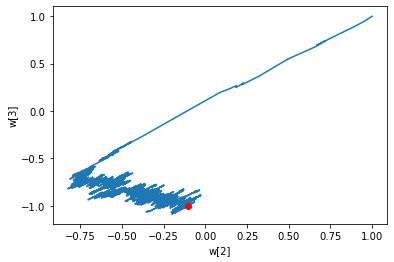

In [18]:
# 2.모델 훈련하기

layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()


w2와 w3의 변화비율이 비슷하기 때문에 대각선 방향으로 가중치 이동.    
두 특성의 스케일을 비슷하게 맞추었으므로 최적값에 빠르게 근접하고 있음.    
경사하강법에서는 서로 다른 특성의 스케일을 맞추는 것이 중요.    


In [19]:
# 3.모델 성능 평가하기

layer2.score(x_val, y_val)

0.37362637362637363

In [20]:
# 검증세트의 스케일을 바꾸지 않았기 때문에 성능이 좋지 않음.
# 4.검증세트도 표준화 전처리 적용

val_mean = np.mean(x_val, axis =0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val -val_mean)/ val_std
layer2.score(x_val_scaled,y_val)


0.967032967032967

### 스케일을 조정한 다음에 실수하기 쉬운 함정.

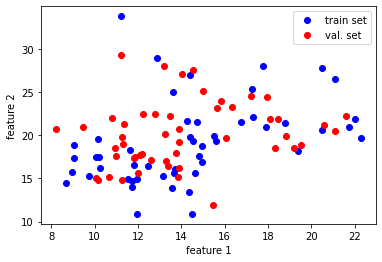

In [21]:
# 1. 원본훈련세트와 검증세트로 산점도 그리기

plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

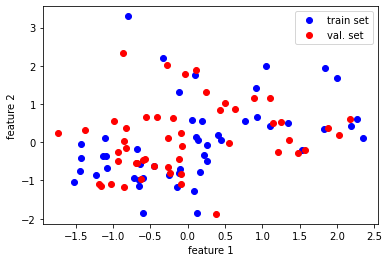

In [22]:
# 2. 전처리한 훈련세트와 검증세트로 산점도 그리기

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

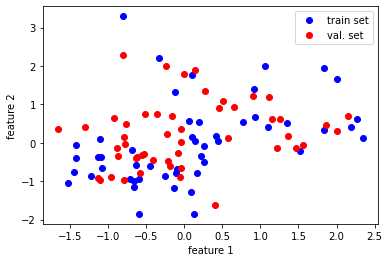

In [23]:
# 3. 올바르게 검증세트 전처리하기. 
# 훈련세트의 평균,표준편차를 사용하여 검증세트 변환.

x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

In [24]:
# 4.모델평가하기 

layer2.score(x_val_scaled, y_val)

0.967032967032967

## 05-2 과대적합과 과소적합

- 과대적합된 모델을 '분산이 크다(high variance)'    
- 과소적합된 모델을 '편향이 크다(high bias)'

In [25]:
# 4.모델 훈련하기
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

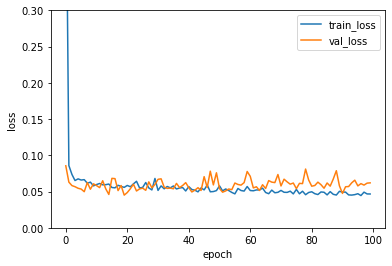

In [28]:
# 5.손실값으로 그래프를 그려 에포크 횟수 지정하기

plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [29]:
# 훈련조기종료하기
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)  # 20번
layer4.score(x_val_scaled, y_val)

0.978021978021978

과대적합 되기 전에 훈련을 멈추었으므로 검증 세트의 성능이 0.967에서 0.978로 조금 향상됨.

### 05-3. 규제 (Regularization)